In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

In [2]:
train = np.load("training_data.npz")["data"]
test = np.load("testing.npz")["data"]

newsGroup = open('newsgrouplabels.txt', 'r')
classes = []
for line in newsGroup:
    nG = line.split()
    classes.append(nG)

In [3]:
X = train[:, 1:-1]
Y = train[:, -1]
test = test[:, 1:]

encoder = OneHotEncoder()
scaler = StandardScaler(with_mean=False)

X = scaler.fit_transform(X)
X = csr_matrix(X)
test = csr_matrix(test)
test = scaler.fit_transform(test)
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size=0.33, random_state=42)

In [4]:
def crossEntropyLoss(yTrue, yPred):
    return -np.sum(yTrue * np.log(yPred + 1e-8), axis=1).mean()

def logisticRegression(xTrain, yTrain, eta, lmbda, itera, minItera=100, tol=1e-4):
    m = xTrain.shape[0]
    k = yTrain.shape[1]
    n = xTrain.shape[1]
    X = hstack([csr_matrix(np.ones((m,1))), xTrain])
    delta = yTrain.T
    W = np.random.normal(loc=0, scale=0.01, size=(k, n+1))

    losses = []
    prevLoss = np.inf

    for iteration in tqdm(range(itera)):
        logits = np.exp(W @ X.T - np.max(W @ X.T, axis = 0, keepdims = True))
        probability = logits / np.sum(logits, axis=0)
        error = (delta - probability) @ X
        W = W + eta * (error - (lmbda * W))

        loss = crossEntropyLoss(delta.T, probability.T) + (lmbda / 2) * np.sum(W**2)
        losses.append(loss)

        # check difference in loss between consecutive iterations
        if prevLoss - loss < tol and iteration > minItera:
            break
        prevLoss = loss
        
    return W, losses

In [5]:
def predict(W, xTest):
    m = xTest.shape[0]
    X = hstack([csr_matrix(np.ones((m,1))), xTest])
    logits = W @ X.T
    probabilities = np.exp(logits - np.max(logits, axis=0, keepdims=True))
    probabilities /= np.sum(probabilities, axis=0)
    yPred = np.argmax(probabilities, axis=0)
    return yPred

In [6]:
W, losses = logisticRegression(xTrain, yTrain, eta = 0.0001, lmbda=0.01, itera=1000, minItera= 50, tol=1e-6)

  5%|██                                       | 51/1000 [00:03<00:59, 15.93it/s]


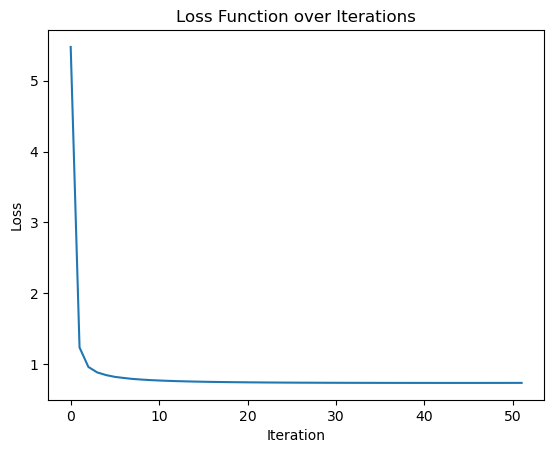

In [7]:
import matplotlib.pyplot as plt

# plot the loss function
plt.plot(losses)
plt.title("Loss Function over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [8]:
yPred = predict(W, xVal)
accuracy = np.mean(np.argmax(yVal, axis=1) == yPred)
print("Accuracy:", accuracy)

Accuracy: 0.729040404040404
